# Prestack seismic

**[Smaller single gather file on S3/agilegeo (3.8GB)](https://s3.amazonaws.com/agilegeo/3D_gathers_pstm_nmo_X1001.sgy)**

**[Larger gathers files on Open Seismic Repository (ca. 10GB)](https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND)**

For now we'll satisfy ourselves with reading some prestack seismic data from disk, and looking at it.

Eventually we can:

- Extract prestack attributes from the gathers.
- Examine a well from one of the gather locations.
- Model the AVO behaviour at the well and compare to the prestack data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def print_header(stream):
    try:
        # Make sure we don't have a ``bytes`` object.
        string = stream.textual_file_header.decode()
    except:
        # String is already a string, carry on.
        pass
    width = 80
    lines = int(np.ceil(len(string) / width))
    result = ''
    for i in range(lines):
        line = string[i*width:i*width+width]
        result += line + (width-len(line))*' ' + '\n'
    print(result)
    return

## Read the SEGY file

This is a large file — and this is only 1 of 30 or so files in this ca. 90GB dataset – so we will use `headonly=True` to only parse the headers with `_read_segy()`, then we can index into the stream as before. The difference is that this time, the data stays on disk until we do that read.

In [3]:
filename = '../data/3D_gathers_pstm_nmo_X1001.sgy'

In [4]:
from obspy.io.segy.segy import _read_segy

# Only read the headers, otherwise you will get memory issues
raw = _read_segy(filename, headonly=True)

In [5]:
raw

610412 traces in the SEG Y structure.

In [6]:
print_header(raw)

C 1 PROCESSED FOR : OETR        AREA: NOVA SCOTIA   OFFSHORE                    
C 2 PROCESSED BY  : KELMAN SEISMIC PROCESSING, DECEMBER 2007                    
C 3 PROJECT       : PENOBSCOT-3D                                                
C 4 BIN LINES     : X LINES 1000-1040   Y LINES 1000-1481                       
C 5 BIN SIZE      : X INT 12.5M         Y INT 25M  DATUM:    0 M                
C 6 VERSION       :  PSTM  gathers  with true amplitude and nmo applied         
C 7 FORMAT: SEGY 32 BIT IBM FLOATING POINT  LENGTH: 0-6000 MS  SI: 4 MS         
C 8 TRACE HEADER INFORMATION                                                    
C 9 BYTE#  1-4  TRACE SEQUENCE # WITHIN VERSION			                              
C12 BYTE#  5-9  INCREMENTAL LINE  NUMBER CDP-X 			                              
C13 BYTE#  9-12 INCREMENTAL LINE  NUMBER CDP-Y		         	                      
C14 BYTE# 13-16 21-24 INCREMENTAL LINE NUMBER CDP-X 	                           
C15 BYTE# 17-20 25-28 INCREM

## Organize the data

This is where we get the data from disk. We'll just grab a bit. There are about 22 traces per gather, so we'll go for 100-ish gathers.

The tricky thing with this dataset is that there are a variable number of traces per gather, so we can't just read it like a regular 3D.

In [7]:
traces_to_read = 2200
data = np.vstack([t.data for t in raw.traces[:traces_to_read]])
gno = np.array([t.header.trace_number_within_the_ensemble for t in raw.traces[:traces_to_read]])

In [8]:
# We'll need the number of time samples.
_, t = data.shape

In [9]:
# Find the max number of traces in a gather.
values, counts = np.unique(gno, return_counts=True)

In [10]:
# Collect all the traces according to the trace header no.
gathers = np.vstack([data[gno==i] for i in values])

In [11]:
# Make a mask, False where there's no trace for that gather.
mask = np.arange(np.amax(counts)) < counts[:, None]

# We have to mask with a 1D array so make the out one row per trace.
out = np.zeros((mask.size, t))
out[np.ravel(mask)] = gathers

In [12]:
lines, traces = mask.shape

# Reshape back to the 3D geometry.
g3 = out.reshape(lines, traces, t)

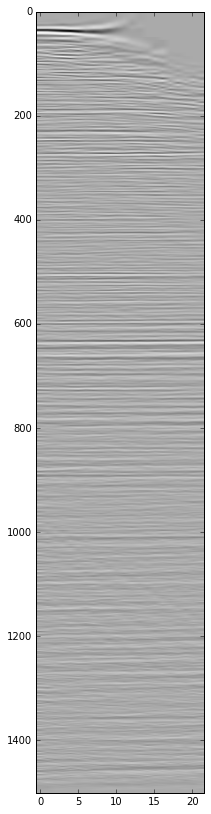

In [13]:
plt.figure(figsize=(3,14))
plt.imshow(g3[68,:].T, cmap='Greys', aspect='auto')
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>